# First G Lookup Table in numpy

- TODO: translate lookup in Tensorflow and integrate to the rest

In [3]:
from scipy.special import hyp1f1
import numpy as np
import matplotlib.pyplot as plt

In [48]:
def hyp_der_approx(a, b, z, eps=10e-10):
    left_approx  = ( hyp1f1(a, b, z) - hyp1f1(a - eps, b, z) ) / eps
    
    return left_approx

## 1. G Sampling

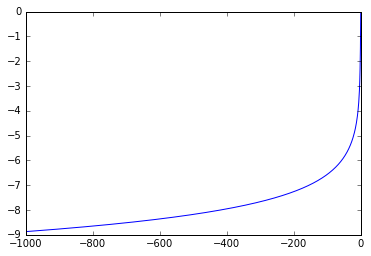

In [50]:
res = 1000
X = np.linspace(-1000, 0, res)
Y = np.array([hyp_der_approx(0, 0.5, i) for i in X])

plt.plot(X, Y)
plt.show()

In [52]:
table = np.array([X, Y])

## 2. Lookup Table

In [117]:
def table_lookup(table, key):
    table_ind = np.argmin( np.abs(table[0] - key) ) 
    shift     = key - table[0, table_ind]
    
    shift_step = np.int(np.sign(shift))
    table_ind_shifted = table_ind + shift_step
    
    table_val = table[1,table_ind]
    next_table_val = table[1, table_ind_shifted]
    
    table_key = table[0, table_ind]
    next_table_key = table[0, table_ind_shifted]
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return interpolated_fun_value, gradient

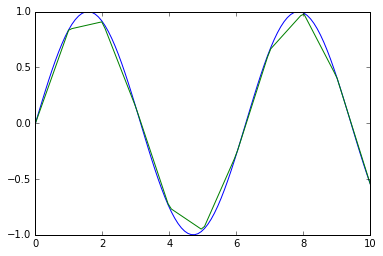

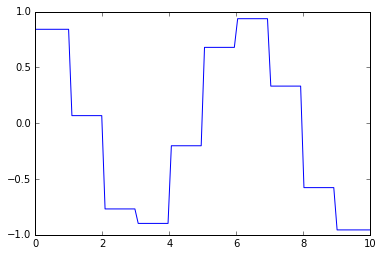

In [131]:
sin_x = np.linspace(0, 10, 11)
sin_y = np.sin(sin_x)
sin_table = np.array([sin_x, sin_y])

grid = np.linspace(0.0001, 9.99999, 102)
vals_grads = np.array([table_lookup(sin_table, x) for x in grid])

plt.plot(grid, np.sin(grid))
plt.plot(grid, vals_grads[:,0])
plt.show()

plt.plot(grid, vals_grads[:,1])
plt.show()

